In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
cd ".."

/Users/aaronkelley/Documents/Academic/School/UNAM/Semestre2/Redes/ProyectoFinal/adversarial-examples


In [3]:
# !conda install pandas -y

In [4]:
from tensorflow.contrib.slim.nets import inception
import tensorflow as tf
import matlab.engine
from config import Config
from cleverhans.attacks import FastGradientMethod
import numpy as np
import os
import pandas as pd
from scipy.misc import imread
from scipy.misc import imsave
from io import BytesIO
from PIL import Image
import IPython.display
from utils.sample_attacks.fgsm.attack_fgsm import save_images

from jpeg_denoise import jpeg
from fourier_whole_denoise import fourier_whole, get_subdirs
from pca_whole_denoise import pca_whole
from pca_blockwise_denoise import pca_blockwise

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
def load_images(input_dir, batch_shape):
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in sorted(tf.gfile.Glob(os.path.join(input_dir, '*.png'))):
        with tf.gfile.Open(filepath, "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images
            filenames = []
            images = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images

def show_image(a, fmt='png'):
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [6]:
class InceptionModel(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.built = False

    def __call__(self, x_input):
        """Constructs model and return probabilities for given input."""
        reuse = True if self.built else None
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            _, end_points = inception.inception_v3(
                            x_input, num_classes=self.num_classes, is_training=False,
                            reuse=reuse)
        self.built = True
        output = end_points['Predictions']
        probs = output.op.inputs[0]
        return probs

In [7]:
slim = tf.contrib.slim 
# categories = pd.read_csv("../project_miscellaneous/nips-2017-defense-against-adversarial-attack/dev_toolkit/dataset/dev_dataset.csv")
categories = pd.read_csv("../project_miscellaneous/nips-2017-adversarial-learning-development-set/inputs/categories.csv")
image_width          = 299
image_height         = 299
checkpoint_path      = "./inception_v3.ckpt"
tensorflow_master   = ''
master               = ''
# max_epsilon          = 16.0
image_width          = 299
image_height         = 299
batch_size           = 1
# eps = 2.0 * max_epsilon / 255.0
batch_shape = [batch_size, image_height, image_width, 3]
num_classes = 1001

tf.logging.set_verbosity(tf.logging.ERROR) # so we don't get a bunch of logging info

# Attacking images with no defense

In [8]:
input_dir            = './demo/original/'
output_dir           = './demo/adversarial/' # currently we're not using the output directory because we're not saving anything

In [18]:
all_eps = np.append(np.linspace(0, 0.2, 21), 1)
all_eps = list(map(lambda x: round(x, 2), all_eps))
adv_images_nodefense = dict()
for eps in all_eps:
    with tf.Graph().as_default():
        # Prepare graph
        x_input = tf.placeholder(tf.float32, shape=batch_shape)

        model = InceptionModel(num_classes)

        fgsm = FastGradientMethod(model)
        x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

        # Run computation
        saver = tf.train.Saver(slim.get_model_variables())
        session_creator = tf.train.ChiefSessionCreator(
                                scaffold=tf.train.Scaffold(saver=saver),
                                checkpoint_filename_with_path=checkpoint_path)

        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            filenames, images = next(load_images(input_dir, batch_shape))
            adv_images_nodefense[eps] = sess.run(x_adv, feed_dict={x_input: images})[0]

In [19]:
predicted_classes_nodefense = dict()
predicted_names_nodefense = dict()
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)
    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        for eps in all_eps:
            predicted_classes = sess.run(predicted_labels, feed_dict={x_input: images})
    #         predicted_classes_nodefense = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
            predicted_classes_nodefense[eps] = sess.run(predicted_labels, feed_dict={x_input: [adv_images_nodefense[eps]]})

            predicted_names_nodefense[eps] = (pd.DataFrame({"CategoryId": predicted_classes_nodefense[eps]})
                                      .merge(categories, on="CategoryId")["CategoryName"].tolist())

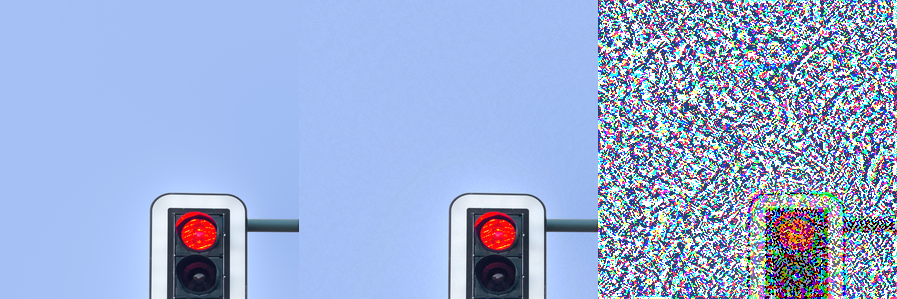

In [20]:
show_image(np.concatenate([adv_images_nodefense[0], adv_images_nodefense[0.01], adv_images_nodefense[1]], axis=1))

In [21]:
print(predicted_names_nodefense[0])
print(predicted_names_nodefense[0.01])
print(predicted_names_nodefense[1])

['traffic light, traffic signal, stoplight']
['iPod']
['paper towel']


# Attacking with just random noise

In [26]:
all_eps = np.append(np.linspace(0, 0.2, 21), 1)
all_eps = list(map(lambda x: round(x, 2), all_eps))
noisy_images = dict()
for eps in all_eps:
    with tf.Graph().as_default():
        x_input = tf.placeholder(tf.float32, shape=batch_shape)
        noisy_im = x_input + eps * tf.sign(tf.random_normal(batch_shape))
        x_output = tf.clip_by_value(noisy_im, 0.0, 1.0)

        with tf.Session(master) as sess:
            filenames, images = next(load_images(input_dir, batch_shape))
            noisy_images[round(eps, 2)] = sess.run(x_output, feed_dict={x_input: images})[0]

In [27]:
predicted_clases_noiseattack = dict()
predicted_names_noiseattack = dict()
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)
    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        for eps in all_eps:
            predicted_classes = sess.run(predicted_labels, feed_dict={x_input: images})
    #         predicted_clases_noiseattack = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
            predicted_clases_noiseattack[eps] = sess.run(predicted_labels, feed_dict={x_input: [noisy_images[eps]]})

            predicted_names_noiseattack[eps] = (pd.DataFrame({"CategoryId": predicted_clases_noiseattack[eps]})
                                      .merge(categories, on="CategoryId")["CategoryName"].tolist())

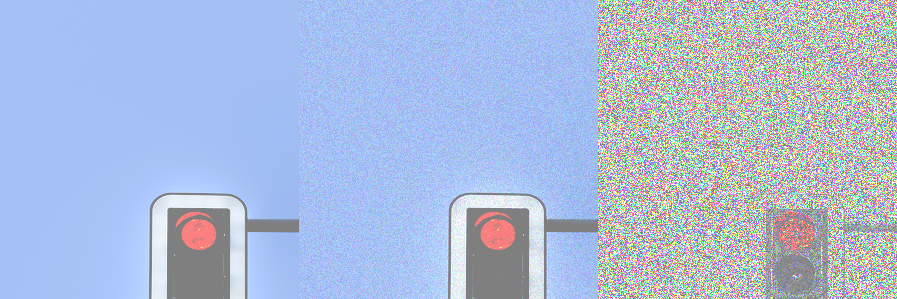

In [29]:
show_image(np.concatenate([noisy_images[0], noisy_images[0.1], noisy_images[1]], axis=1))

I don't know why the images loses some intensitiy...we'll have to debug this

In [30]:
print(predicted_names_noiseattack[0])
print(predicted_names_noiseattack[0.1])
print(predicted_names_noiseattack[1])

['traffic light, traffic signal, stoplight']
['traffic light, traffic signal, stoplight']
['loudspeaker, speaker, speaker unit, loudspeaker system, speaker system']


 # Apply JPEG Defense

In [12]:
attack_base_dir            = './demo'
denoise_base_dir           = './'
out_images = jpeg(attack_base_dir, denoise_base_dir, 23) # last parameter is quality of compression (1-100%)

In [13]:
# rename jpg back to png so the network will classify it
for out_dir in out_images:
    for im in os.listdir(out_dir):
        path = out_dir + im
        os.rename(path, path.replace('.jpg', '.png'))
        

In [14]:
input_dir            = './jpeg_23/demo/original'
output_dir           = './demo1/adversarial'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Run attack against JPEG images

In [15]:
all_eps = np.append(np.linspace(0, 0.2, 21), 1)
all_eps = list(map(lambda x: round(x, 2), all_eps))
adv_images_jpeg = dict()
for eps in all_eps:
    with tf.Graph().as_default():
        # Prepare graph
        x_input = tf.placeholder(tf.float32, shape=batch_shape)

        model = InceptionModel(num_classes)

        fgsm = FastGradientMethod(model)
        x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

        # Run computation
        saver = tf.train.Saver(slim.get_model_variables())
        session_creator = tf.train.ChiefSessionCreator(
                                scaffold=tf.train.Scaffold(saver=saver),
                                checkpoint_filename_with_path=checkpoint_path)

        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            filenames, images = next(load_images(input_dir, batch_shape))
            adv_images_jpeg[eps] = sess.run(x_adv, feed_dict={x_input: images})[0]

In [18]:
predicted_classes_jpegdefense = dict()
predicted_names_jpegdefense = dict()
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)
    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        for eps in all_eps:
            predicted_classes_jpegdefense[eps] = sess.run(predicted_labels, feed_dict={x_input: images})
    #         predicted_classes_jpegdefense = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
            predicted_classes_jpegdefense[eps] = sess.run(predicted_labels, feed_dict={x_input: [adv_images_jpeg[eps]]})

            predicted_names_jpegdefense[eps] = (pd.DataFrame({"CategoryId": predicted_classes_jpegdefense[eps]})
                                      .merge(categories, on="CategoryId")["CategoryName"].tolist())

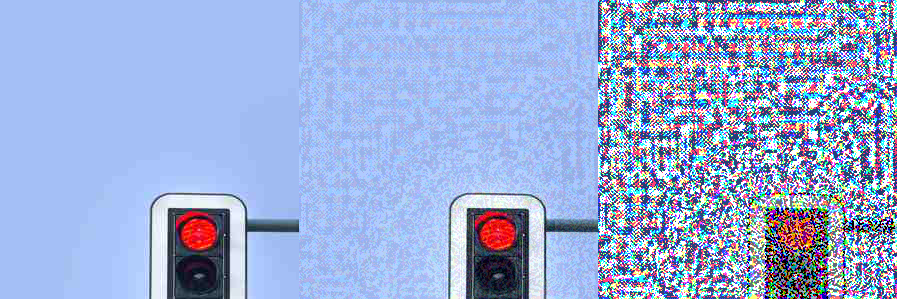

In [17]:
show_image(np.concatenate([adv_images_jpeg[0], adv_images_jpeg[0.1], adv_images_jpeg[1]], axis=1))

In [19]:
print(predicted_names_jpegdefense[0])
print(predicted_names_jpegdefense[0.01])
print(predicted_names_jpegdefense[1])

['traffic light, traffic signal, stoplight']
['cellular telephone, cellular phone, cellphone, cell, mobile phone']
['apron']


# PCA whole

In [20]:
attack_base_dir            = './demo'
denoise_base_dir           = './'

In [21]:
pca_whole(attack_base_dir, denoise_base_dir, 36) # last parameter is number of PCs

./pca_whole_36/demo/original/


In [23]:
input_dir            = './pca_whole_36/demo/original'
output_dir           = './demo2/adversarial'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [24]:
all_eps = np.append(np.linspace(0, 0.2, 21), 1)
all_eps = list(map(lambda x: round(x, 2), all_eps))
adv_images_pcawhole = dict()
for eps in all_eps:
    with tf.Graph().as_default():
        # Prepare graph
        x_input = tf.placeholder(tf.float32, shape=batch_shape)

        model = InceptionModel(num_classes)

        fgsm = FastGradientMethod(model)
        x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

        # Run computation
        saver = tf.train.Saver(slim.get_model_variables())
        session_creator = tf.train.ChiefSessionCreator(
                                scaffold=tf.train.Scaffold(saver=saver),
                                checkpoint_filename_with_path=checkpoint_path)

        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            filenames, images = next(load_images(input_dir, batch_shape))
            adv_images_pcawhole[eps] = sess.run(x_adv, feed_dict={x_input: images})[0]

In [25]:
predicted_classes_pcawholedefense = dict()
predicted_names_pcawholedefense = dict()
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)
    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        for eps in all_eps:
            predicted_classes_pcawholedefense[eps] = sess.run(predicted_labels, feed_dict={x_input: images})
    #         predicted_classes_pcawholedefense = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
            predicted_classes_pcawholedefense[eps] = sess.run(predicted_labels, feed_dict={x_input: [adv_images_pcawhole[eps]]})

            predicted_names_pcawholedefense[eps] = (pd.DataFrame({"CategoryId": predicted_classes_pcawholedefense[eps]})
                                      .merge(categories, on="CategoryId")["CategoryName"].tolist())

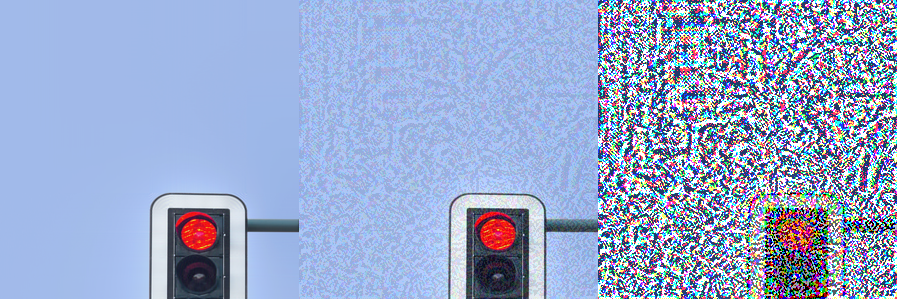

In [28]:
show_image(np.concatenate([adv_images_pcawhole[0], adv_images_pcawhole[0.1], adv_images_pcawhole[1]], axis=1))

In [29]:
print(predicted_names_pcawholedefense[0])
print(predicted_names_pcawholedefense[0.01])
print(predicted_names_pcawholedefense[1])

['traffic light, traffic signal, stoplight']
['iPod']
['doormat, welcome mat']


# PCA blockwise

In [8]:
attack_base_dir            = './demo'
denoise_base_dir           = './'

In [9]:
pca_blockwise(attack_base_dir, denoise_base_dir, 13) # last parameter is number of PCs per block

./pca_blockwise_13/demo/original/


In [10]:
input_dir            = './pca_blockwise_13/demo/original'
output_dir           = './demo3/adversarial'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
all_eps = np.append(np.linspace(0, 0.2, 21), 1)
all_eps = list(map(lambda x: round(x, 2), all_eps))
adv_images_pcablockwise = dict()
for eps in all_eps:
    with tf.Graph().as_default():
        # Prepare graph
        x_input = tf.placeholder(tf.float32, shape=batch_shape)

        model = InceptionModel(num_classes)

        fgsm = FastGradientMethod(model)
        x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

        # Run computation
        saver = tf.train.Saver(slim.get_model_variables())
        session_creator = tf.train.ChiefSessionCreator(
                                scaffold=tf.train.Scaffold(saver=saver),
                                checkpoint_filename_with_path=checkpoint_path)

        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            filenames, images = next(load_images(input_dir, batch_shape))
            adv_images_pcablockwise[eps] = sess.run(x_adv, feed_dict={x_input: images})[0]

In [ ]:
predicted_classes_pcablockwisedefense = dict()
predicted_names_pcablockwisedefense = dict()
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)
    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        for eps in all_eps:
            predicted_classes_pcablockwisedefense[eps] = sess.run(predicted_labels, feed_dict={x_input: images})
    #         predicted_classes_pcablockwisedefense = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
            predicted_classes_pcablockwisedefense[eps] = sess.run(predicted_labels, feed_dict={x_input: [adv_images_pcablockwise[eps]]})

            predicted_names_pcablockwisedefense[eps] = (pd.DataFrame({"CategoryId": predicted_classes_pcablockwisedefense[eps]})
                                      .merge(categories, on="CategoryId")["CategoryName"].tolist())

In [ ]:
show_image(np.concatenate([adv_images_pcablockwise[0], adv_images_pcablockwise[0.1], adv_images_pcablockwise[1]], axis=1))

In [ ]:
print(predicted_names_pcablockwisedefense[0])
print(predicted_names_pcablockwisedefense[0.01])
print(predicted_names_pcablockwisedefense[1])

# Some old helper funtions that I can't remember if they're still helpful

In [ ]:
def load_images_helper(image_list, imgdir_path, imgdir_denoised, batch_shape, img_fmt):
    images = np.zeros(batch_shape)
    images_denoised = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in image_list:
        with tf.gfile.Open(os.path.join(imgdir_path, filepath), "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        if img_fmt == 'jpg':
            filepath = filepath.replace('png', img_fmt)
        with tf.gfile.Open(os.path.join(imgdir_denoised, filepath), "rb") as f:
            images_denoised[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        if img_fmt == 'jpg':
            filepath = filepath.replace(img_fmt, 'png')
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images_denoised, images
            filenames = []
            images = np.zeros(batch_shape)
            images_denoised = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images_denoised, images

In [ ]:
def get_image_list(benign_dir, random_seed, subset_num):
    images_whole      = [f for f in os.listdir(benign_dir) if os.path.isfile(os.path.join(benign_dir, f))]
    images_whole      = sorted(images_whole)

    if random_seed != None:
        random.seed(random_seed)
        # generate random indices to subset
        subset_ids  = random.sample(range(len(images_whole)), subset_num)  
    else:
        subset_ids  = range(subset_num)

    image_list = [images_whole[i] for i in subset_ids]
    return image_list

In [ ]:
def save_images(images, filenames, output_dir):
    for i, filename in enumerate(filenames):
        img = np.uint8(((images[i, :, :, :] + 1.0) * 0.5) * 255.0)
        imsave(output_dir+filename, img)

In [11]:
def load_images(input_dir, batch_shape):
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in sorted(tf.gfile.Glob(os.path.join(input_dir, '*.png'))):
        with tf.gfile.Open(filepath, "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images
            filenames = []
            images = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images

def show_image(a, fmt='png'):
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
